In [1]:
import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

sys.path.append(os.path.abspath(".."))
from src.data_setup import load_data, split_cities
from src.pipeline import create_pipeline
from src.inference import create_diff_target, predict_on_test, predict_on_test_normal
from src.visualization import visualize_predictions

In [2]:
features_train, target_train = load_data(train=True)
sj_features_train, iq_features_train = split_cities(features_train)
sj_target_train, iq_target_train = split_cities(target_train)

features_test, _ = load_data(train=False)
sj_features_test, iq_features_test = split_cities(features_test)

In [14]:
cases_values = sj_target_train.reset_index()["total_cases"].values

In [3]:
sj_diff_target, sj_target_merged = create_diff_target(sj_target_train)
iq_diff_target, iq_target_merged = create_diff_target(iq_target_train)

In [4]:
aggregation_periods = [1, 2, 3, 4]
cols_to_aggregate = ['precipitation_amt_mm',
                      'reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_precip_amt_kg_per_m2',
                      'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm', 'station_precip_mm']
k_prev = 10

sj_train_pipeline = create_pipeline(aggregation_periods=aggregation_periods,
                                 cols_to_aggregate=cols_to_aggregate,
                                 date_column="week_start_date",
                                 k_prev=k_prev,
                                 test=False)

sj_test_pipeline = create_pipeline(aggregation_periods=aggregation_periods,
                                 cols_to_aggregate=cols_to_aggregate,
                                 date_column="week_start_date",
                                 k_prev=k_prev,
                                 test=True)

iq_train_pipeline = create_pipeline(aggregation_periods=aggregation_periods,
                                 cols_to_aggregate=cols_to_aggregate,
                                 date_column="week_start_date",
                                 k_prev=k_prev,
                                 test=False)

iq_test_pipeline = create_pipeline(aggregation_periods=aggregation_periods,
                                 cols_to_aggregate=cols_to_aggregate,
                                 date_column="week_start_date",
                                 k_prev=k_prev,
                                 test=True)

In [5]:
sj_features_train_transformed = sj_train_pipeline.fit_transform(sj_features_train, sj_target_train)
iq_features_train_transformed = iq_train_pipeline.fit_transform(iq_features_train, iq_target_train)

In [6]:
sj_test_pipeline.fit(sj_features_train, sj_target_train)
iq_test_pipeline.fit(iq_features_train, iq_target_train)

sj_features_test_transformed = sj_test_pipeline.transform(sj_features_test)
iq_features_test_transformed = iq_test_pipeline.transform(iq_features_test)

# Training

In [7]:
PARAM_GRID_RF = {
    'n_estimators': [200, 500],
    'max_depth': [1, 10, 20, 30],
    'min_samples_split': [1, 10, 15, 20, 30],
    'min_samples_leaf': [1, 5, 10, 20, 30]
}

model = RandomForestRegressor()

In [8]:
random_search = RandomizedSearchCV(estimator=model, 
                                   param_distributions=PARAM_GRID_RF, 
                                   n_iter=50, 
                                   scoring='neg_mean_absolute_error', 
                                   cv=5,  
                                   random_state=42, 
                                   n_jobs=-1,
                                   verbose=0)

In [ ]:
random_search.fit(sj_features_train_transformed, sj_target_train.values.squeeze())

In [14]:
sj_model = random_search.best_estimator_

In [19]:
joblib.dump(sj_model, "../models/rfr_sj_normal.pkl")

['../models/rfr_sj_normal.pkl']

In [ ]:
random_search.fit(iq_features_train_transformed, iq_target_train.values.squeeze())

In [17]:
iq_model = random_search.best_estimator_

In [20]:
joblib.dump(iq_model, "../models/rfr_iq_normal.pkl")

['../models/rfr_iq_normal.pkl']

# Predicting target

In [7]:
sj_model = joblib.load("../models/rfr_sj_normal.pkl")
iq_model = joblib.load("../models/rfr_iq_normal.pkl")

In [8]:
sj_test_predictions = np.maximum(predict_on_test_normal(sj_features_test_transformed, sj_model), 0)
iq_test_predictions = np.maximum(predict_on_test_normal(iq_features_test_transformed, iq_model), 0)

In [9]:
sj_test_predictions_series = pd.Series(sj_test_predictions, index=sj_features_test.index)
iq_test_predictions_series = pd.Series(iq_test_predictions, index=iq_features_test.index)

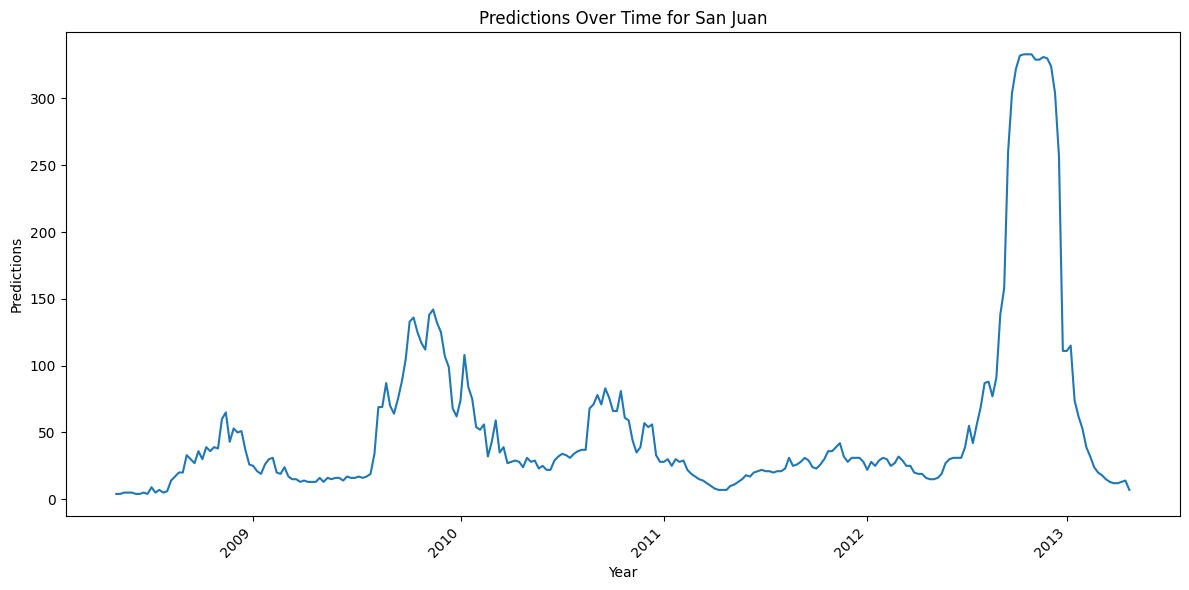

In [12]:
sj_test_predictions_series_ma = sj_test_predictions_series.rolling(window=3, center=True).mean()

visualize_predictions(sj_test_predictions_series_ma, "sj")

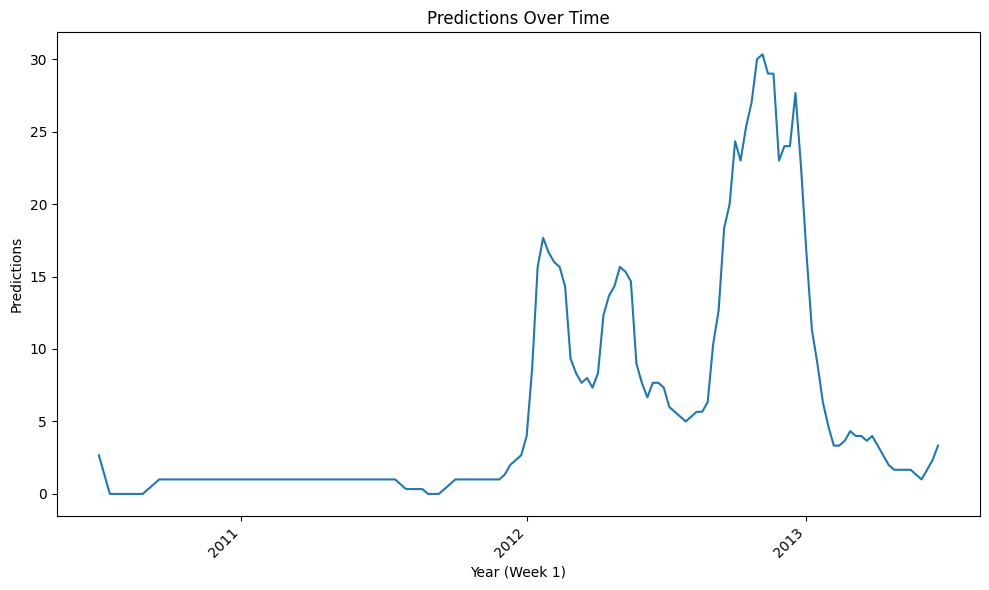

In [27]:
iq_test_predictions_series_ma = iq_test_predictions_series.rolling(window=3, center=True).mean()

visualize_predictions(iq_test_predictions_series_ma)

# Predicting difference from mean

In [7]:
sj_model = joblib.load("../models/rfr_sj_diff.pkl")
iq_model = joblib.load("../models/rfr_iq_diff.pkl")

In [8]:
sj_test_predictions = np.maximum(predict_on_test(sj_features_test_transformed, sj_target_train, sj_model), 0)
iq_test_predictions = np.maximum(predict_on_test(iq_features_test_transformed, iq_target_train, iq_model), 0)

In [9]:
sj_test_predictions_series = pd.Series(sj_test_predictions, index=sj_features_test.index)
iq_test_predictions_series = pd.Series(iq_test_predictions, index=iq_features_test.index)

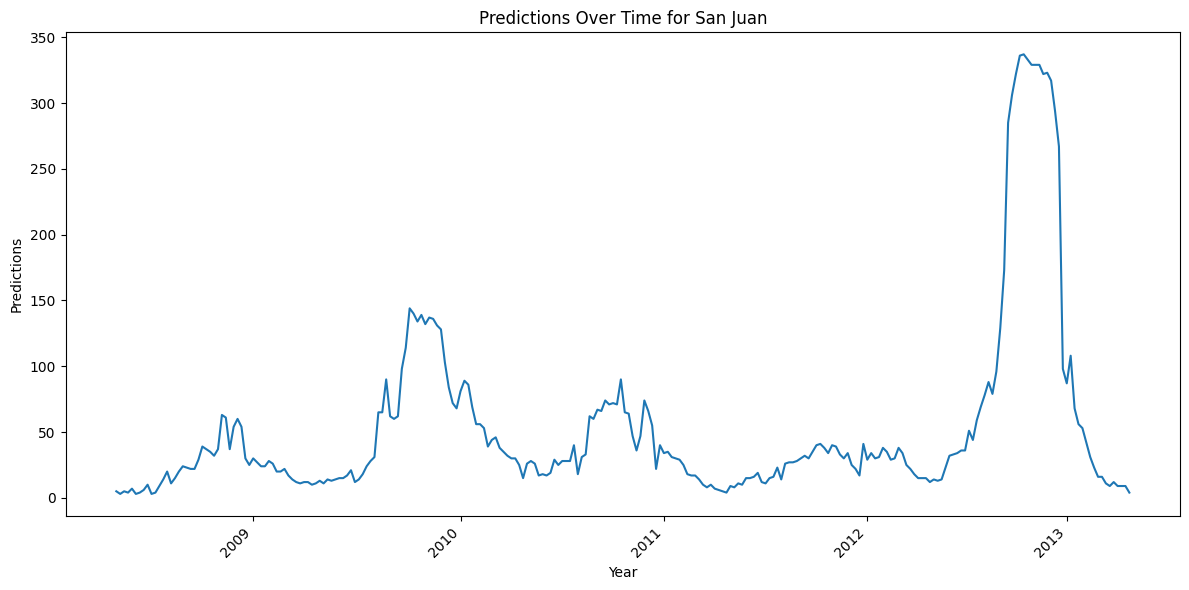

In [12]:
visualize_predictions(sj_test_predictions_series, "sj")

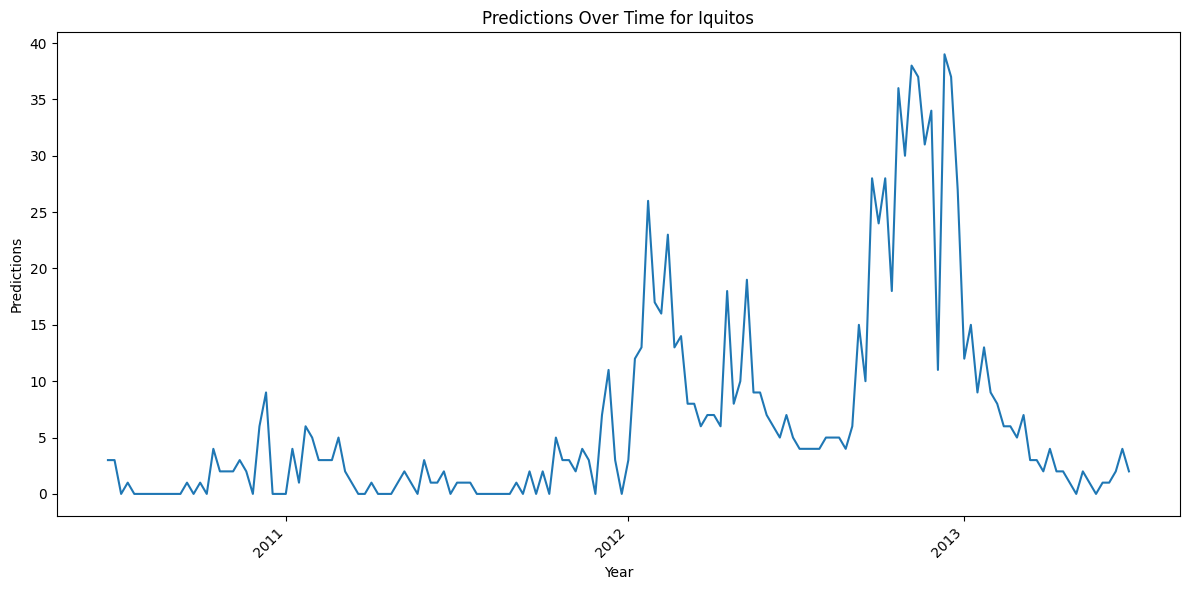

In [13]:
visualize_predictions(iq_test_predictions_series, "iq")